In [1]:
import pandas as pd
import pickle

from sklearn.preprocessing import StandardScaler

from pymongo import MongoClient
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

## Connect to MongoDB - Get Spotify Data

In [2]:
client = MongoClient()
db = client.get_database('spotify')
db.list_collection_names()

['track_features', 'tracks', 'artists', 'albums', 'track_analysis']

In [3]:
cursor = db.track_features.find({}, {'_id': 0, 'duration_ms': 0,
                                     'time_signature': 0, 'tempo': 0,
                                     'mode': 0, 'key': 0})
track_features_df = pd.DataFrame(list(cursor))
track_features_df.rename(columns={'id': 'spotify_song_id'}, inplace=True)

## Grab the Genius Data and Merge

In [4]:
df = pd.read_pickle('../Data/tf_idf_pca_features')
df.drop('duration_ms', axis=1, inplace=True)

In [5]:
df.shape

(15340, 19)

In [6]:
df = df.merge(track_features_df, on='spotify_song_id')
df.drop(['track_number', 'genius_song_id', 'genius_artist_id'],
        axis=1, inplace=True)

In [7]:
df.head(2)

,spotify_album_uri,spotify_artist_id,artist_name,spotify_artist_uri,explicit,spotify_song_id,song_title,song_spotify_page,spotify_song_uri,unaltered_song_title,...,danceability,energy,instrumentalness,liveness,loudness,speechiness,track_href,type,uri,valence
0,spotify:album:4vQcWE7Ce6ORsatrqXkBtt,14H7ag1wpQOsPPQJOD6Dqr,zero,spotify:artist:14H7ag1wpQOsPPQJOD6Dqr,False,2dqpsVfEE3SWltmZ7UWb0m,i have seen,https://open.spotify.com/track/2dqpsVfEE3SWltm...,spotify:track:2dqpsVfEE3SWltmZ7UWb0m,I Have Seen,...,0.485,0.664,0.57,0.120,-8.003,0.0306,https://api.spotify.com/v1/tracks/2dqpsVfEE3SW...,audio_features,spotify:track:2dqpsVfEE3SWltmZ7UWb0m,0.742
1,spotify:album:4vQcWE7Ce6ORsatrqXkBtt,14H7ag1wpQOsPPQJOD6Dqr,zero,spotify:artist:14H7ag1wpQOsPPQJOD6Dqr,False,3C6fiZI9I8xEMbUSfXfQCD,simple things,https://open.spotify.com/track/3C6fiZI9I8xEMbU...,spotify:track:3C6fiZI9I8xEMbUSfXfQCD,Simple Things,...,0.331,0.412,0.23,0.131,-8.576,0.0284,https://api.spotify.com/v1/tracks/3C6fiZI9I8xE...,audio_features,spotify:track:3C6fiZI9I8xEMbUSfXfQCD,0.246


## Separate Features Columns from other data

In [8]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [9]:
features = df.select_dtypes(include=numerics)
no_features = df.select_dtypes(exclude=numerics)

In [10]:
ss = StandardScaler()
scaled_features = ss.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features)
scaled_features.columns = features.columns
track_features_df = pd.merge(no_features, scaled_features,
                             right_index=True, left_index=True)
track_features_df.rename(columns={'id': 'spotify_song_id'}, inplace=True)

## Checking Inertia

In [11]:
KMeans_df = track_features_df.select_dtypes(include=numerics)

inertia = []
i = 2
while i <= 30:
    num_clusters = i
    km = KMeans(n_clusters=num_clusters, n_jobs=-1, n_init=50)
    km.fit(KMeans_df.values)
    inertia.append(km.inertia_)
    i += 1

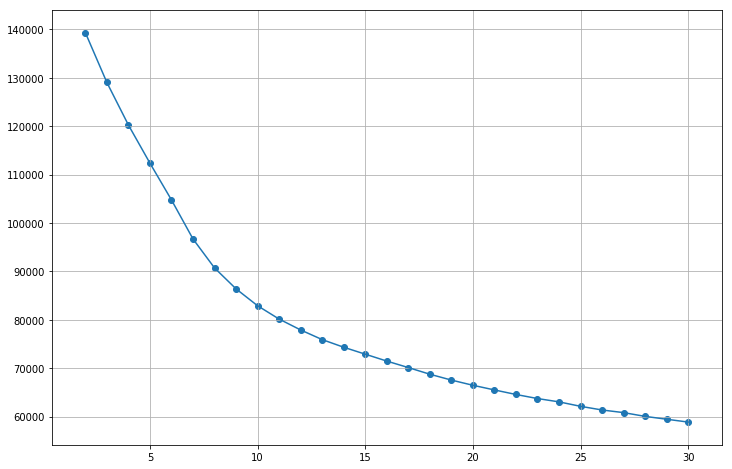

In [12]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(range(2, 31, 1), inertia)
plt.scatter(range(2, 31, 1), inertia)

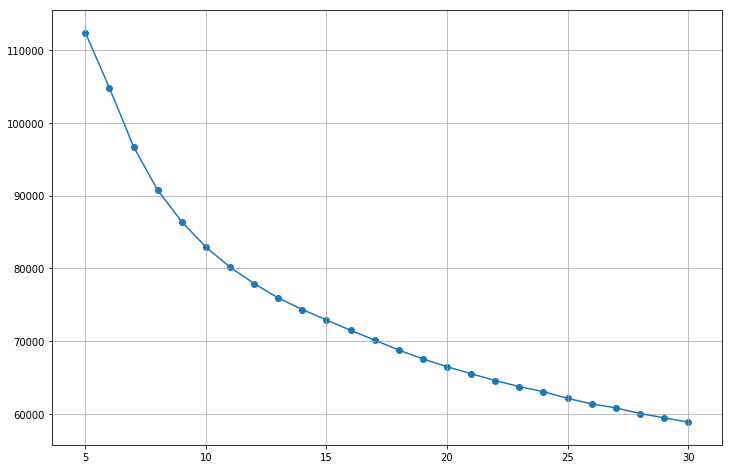

In [13]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(range(5, 31, 1), inertia[3:])
plt.scatter(range(5, 31, 1), inertia[3:])

In [14]:
km = KMeans(n_clusters=12, n_jobs=-1, n_init=50)
km.fit(KMeans_df.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=50, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
pd.Series(km.labels_).value_counts()

7     2767
4     2171
5     1970
2     1630
6     1598
3     1450
8     1222
1      727
0      717
9      484
11     385
10     185
dtype: int64

In [16]:
pickle_out = open('../Data/cluster_centers_tfidf_pca_12', 'wb')
pickle.dump(km.cluster_centers_, pickle_out)
pickle_out.close()

In [17]:
KMeans_df = track_features_df.select_dtypes(include=numerics)

In [18]:
df = (track_features_df.merge(
    pd.DataFrame(km.labels_, columns=['labels']),
    left_index=True, right_index=True))

In [19]:
df.to_pickle('../Data/labeled_points_tf-idf_pca_12')